In [40]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import os

import utils_code.park_visits_change_rate as pvcr

# inline plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.style.use("seaborn")

# autoreload settings (for modules)
%load_ext autoreload
%autoreload 2

# turn off certain warning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

### Main data

In [17]:
cbg_connections = pd.read_csv("../data/cbg_connections_processed.csv", parse_dates=['date'],
                              dtype={'visitor_home_cbg': str, 'GEOID_origin': str, 'GEOID_dest': str,
                                     'visitor_home_county': str, 'visitor_dest_county': str})

In [18]:
cbg_connections = cbg_connections[cbg_connections['visitor_home_county'].isin(['36005','36047','36061','36081','36085'])]

In [38]:
# cbg_connections.info()

### Income data

In [2]:
# nyc income data by CBG
nyc_acs_income_data = pd.read_csv("../data/income/nyc_acs_income_data_2019.csv")

In [3]:
nyc_acs_income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cbg_id                      6493 non-null   int64  
 1   Geographic Area Name        6493 non-null   object 
 2   per_capita_income           6211 non-null   float64
 3   median_household_income     5751 non-null   float64
 4   aggregate_household_income  6187 non-null   float64
 5   county_id                   6493 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 304.5+ KB


In [9]:
# income of the parks' neighborhoods (processed from ArcGIS Pro)
nyc_parks_nbhd_income = pd.read_csv("../data/income/nyc_parks_nbhd_income.csv")

In [39]:
nyc_parks_nbhd_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526 entries, 0 to 1525
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   safegraph_place_id          1526 non-null   object 
 1   parknum                     1525 non-null   object 
 2   per_capita_income           1526 non-null   int64  
 3   median_household_income     1389 non-null   float64
 4   aggregate_household_income  1496 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 59.7+ KB


## Visits Change Rate by Park CBG's Income Level 

In [12]:
park_local_visitors_change = pd.read_csv("../data/park_visits_change_rate/park_local_visitors_change.csv")

# change certain columns' type to category
park_local_visitors_change['park_type'] = park_local_visitors_change['park_type'].astype('category')
park_local_visitors_change['month'] = park_local_visitors_change['month'].astype('category')
park_local_visitors_change['borough'] = park_local_visitors_change['borough'].astype('category')

In [20]:
# expand data to make each record as an individual
cbg_connections = cbg_connections.loc[cbg_connections.index.repeat(cbg_connections['visitor_count'])].reset_index()

In [22]:
# combine cbg_connections data with income data
cbg_connections_dest_income = pd.merge(cbg_connections, nyc_parks_nbhd_income, on='safegraph_place_id', how='left')
cbg_connections_dest_income = pvcr.label_income_group(cbg_connections_dest_income, nyc_acs_income_data, 'per_capita_income', 3)    # divide data into 3 income groups
park_dest_income = cbg_connections_dest_income[['park_name', 'parknum', 'park_type', 'visitor_dest_county_name', 'income_group',
                                                'per_capita_income', 'median_household_income', 'aggregate_household_income']].drop_duplicates().reset_index()


park_local_visitors_change_dest_income = pd.merge(park_local_visitors_change, park_dest_income,
                                                  left_on=['park_name', 'park_type', 'borough'],
                                                  right_on=['park_name', 'park_type', 'visitor_dest_county_name'], how='left')

### All parks

In [23]:
# get the data summary
data = park_local_visitors_change_dest_income
groupby_cols = ['income_group', 'month']
value_cols = ['visits_base_adjtd', 'visitor_count_2020']
topic = 'income_group'
test_method = 'wilcoxon'

summary_all = pvcr.summary_by_topic(data, groupby_cols, value_cols, topic, test_method)

In [27]:
# get the tukey's hsd test labels
data = summary_all
value_col = 'visits_change_rate'
topic = 'income_group'

res_df, group_letters = pvcr.tukeyhsd_test(data, value_col, topic, filter_month=True)

#### Simple Summary

In [25]:
data = park_local_visitors_change_dest_income
topic_col = 'income_group'
value_cols = ['visits_base_adjtd', 'visitor_count_2020']

summary = pvcr.summary_by_topic_simple(data, topic_col, value_cols)

In [26]:
summary

,visits_2019,visits_2020,visits_change_rate
income_group,,,
lower,3.243259e+06,1489705.0,-54.1
middle,1.676818e+06,894321.0,-46.7
upper,1.581638e+06,968405.0,-38.8


### Individual park types

In [28]:
# get the data summary
data = park_local_visitors_change_dest_income
groupby_cols = ['park_type', 'income_group', 'month']
value_cols = ['visits_base_adjtd', 'visitor_count_2020']
topic = 'income_group'
test_method = 'wilcoxon'
complete_report = False

summary_groups = pvcr.summary_by_topic(data, groupby_cols, value_cols, topic, test_method, complete_report)

In [29]:
# get the tukey's hsd test labels
data = summary_groups
value_col = 'visits_change_rate'
topic = 'income_group'
subtopic = 'park_type'

res_dfs, group_letters = pvcr.tukeyhsd_test(data, value_col, topic, subtopic, filter_month=True)

### Combined Plot

In [30]:
# combined summary
summary1 = summary_all.reset_index()
summary2 = summary_groups.reset_index()

summary1['park_type'] = 'Overall'
summary_combined = pd.concat([summary1, summary2])
summary_combined = summary_combined.set_index(['park_type', 'income_group', 'month'])

In [31]:
summary_combined

visits_2019  visits_2020  \
park_type      income_group month                               
Overall        lower        1      202488.504139     205693.0   
                            2      186248.865629     184411.0   
                            3      239278.296241     147845.0   
                            4      284873.630126      63389.0   
                            5      334635.302877     108588.0   
...                                          ...          ...   
Triangle/Plaza upper        8        2926.525158       1036.0   
                            9        3880.565673       1498.0   
                            10       3395.213438       1155.0   
                            11       3430.245921       1224.0   
                            12       2832.700191        993.0   

                                   visits_change_rate  test_stat       p_value  
park_type      income_group month                                               
Overall        lower        1                     1.6     9903.0  1.460419e-04  
                            2                    -1.0    11398.0  1.804471e-02  
                            3                   -38.2      956.0  1.984277e-34  
                            4                   -77.7        0.0  1.148577e-38  
                            5                   -67.6      211.0  1.829589e-38  
...                                               ...        ...           ...  
Triangle/Plaza upper        8                   -64.6        3.0  3.906250e-02  
                            9                   -61.4        6.0  1.093750e-01  
                            10                  -66.0        2.0  1.171875e-02  
                            11                  -64.3        0.0  3.906250e-03  
                            12                  -64.9        0.0  3.906250e-03  

[324 rows x 5 columns]

In [32]:
# get the tukey's hsd test labels
data = summary_combined
value_col = 'visits_change_rate'
topic = 'income_group'
subtopic = 'park_type'

res_dfs, group_letters = pvcr.tukeyhsd_test(data, value_col, topic, subtopic, filter_month=True)

In [35]:
# the major park types that attracted more than 90% of the total visits
major_park_types = ['Community Park', 'Flagship Park', 'Jointly Operated Playground', 'Nature Area',
                    'Neighborhood Park', 'Playground', 'Recreation Field/Courts', 'Triangle/Plaza']
# add an Overall type
major_park_types_combined = major_park_types.copy()
major_park_types_combined.insert(0, 'Overall')

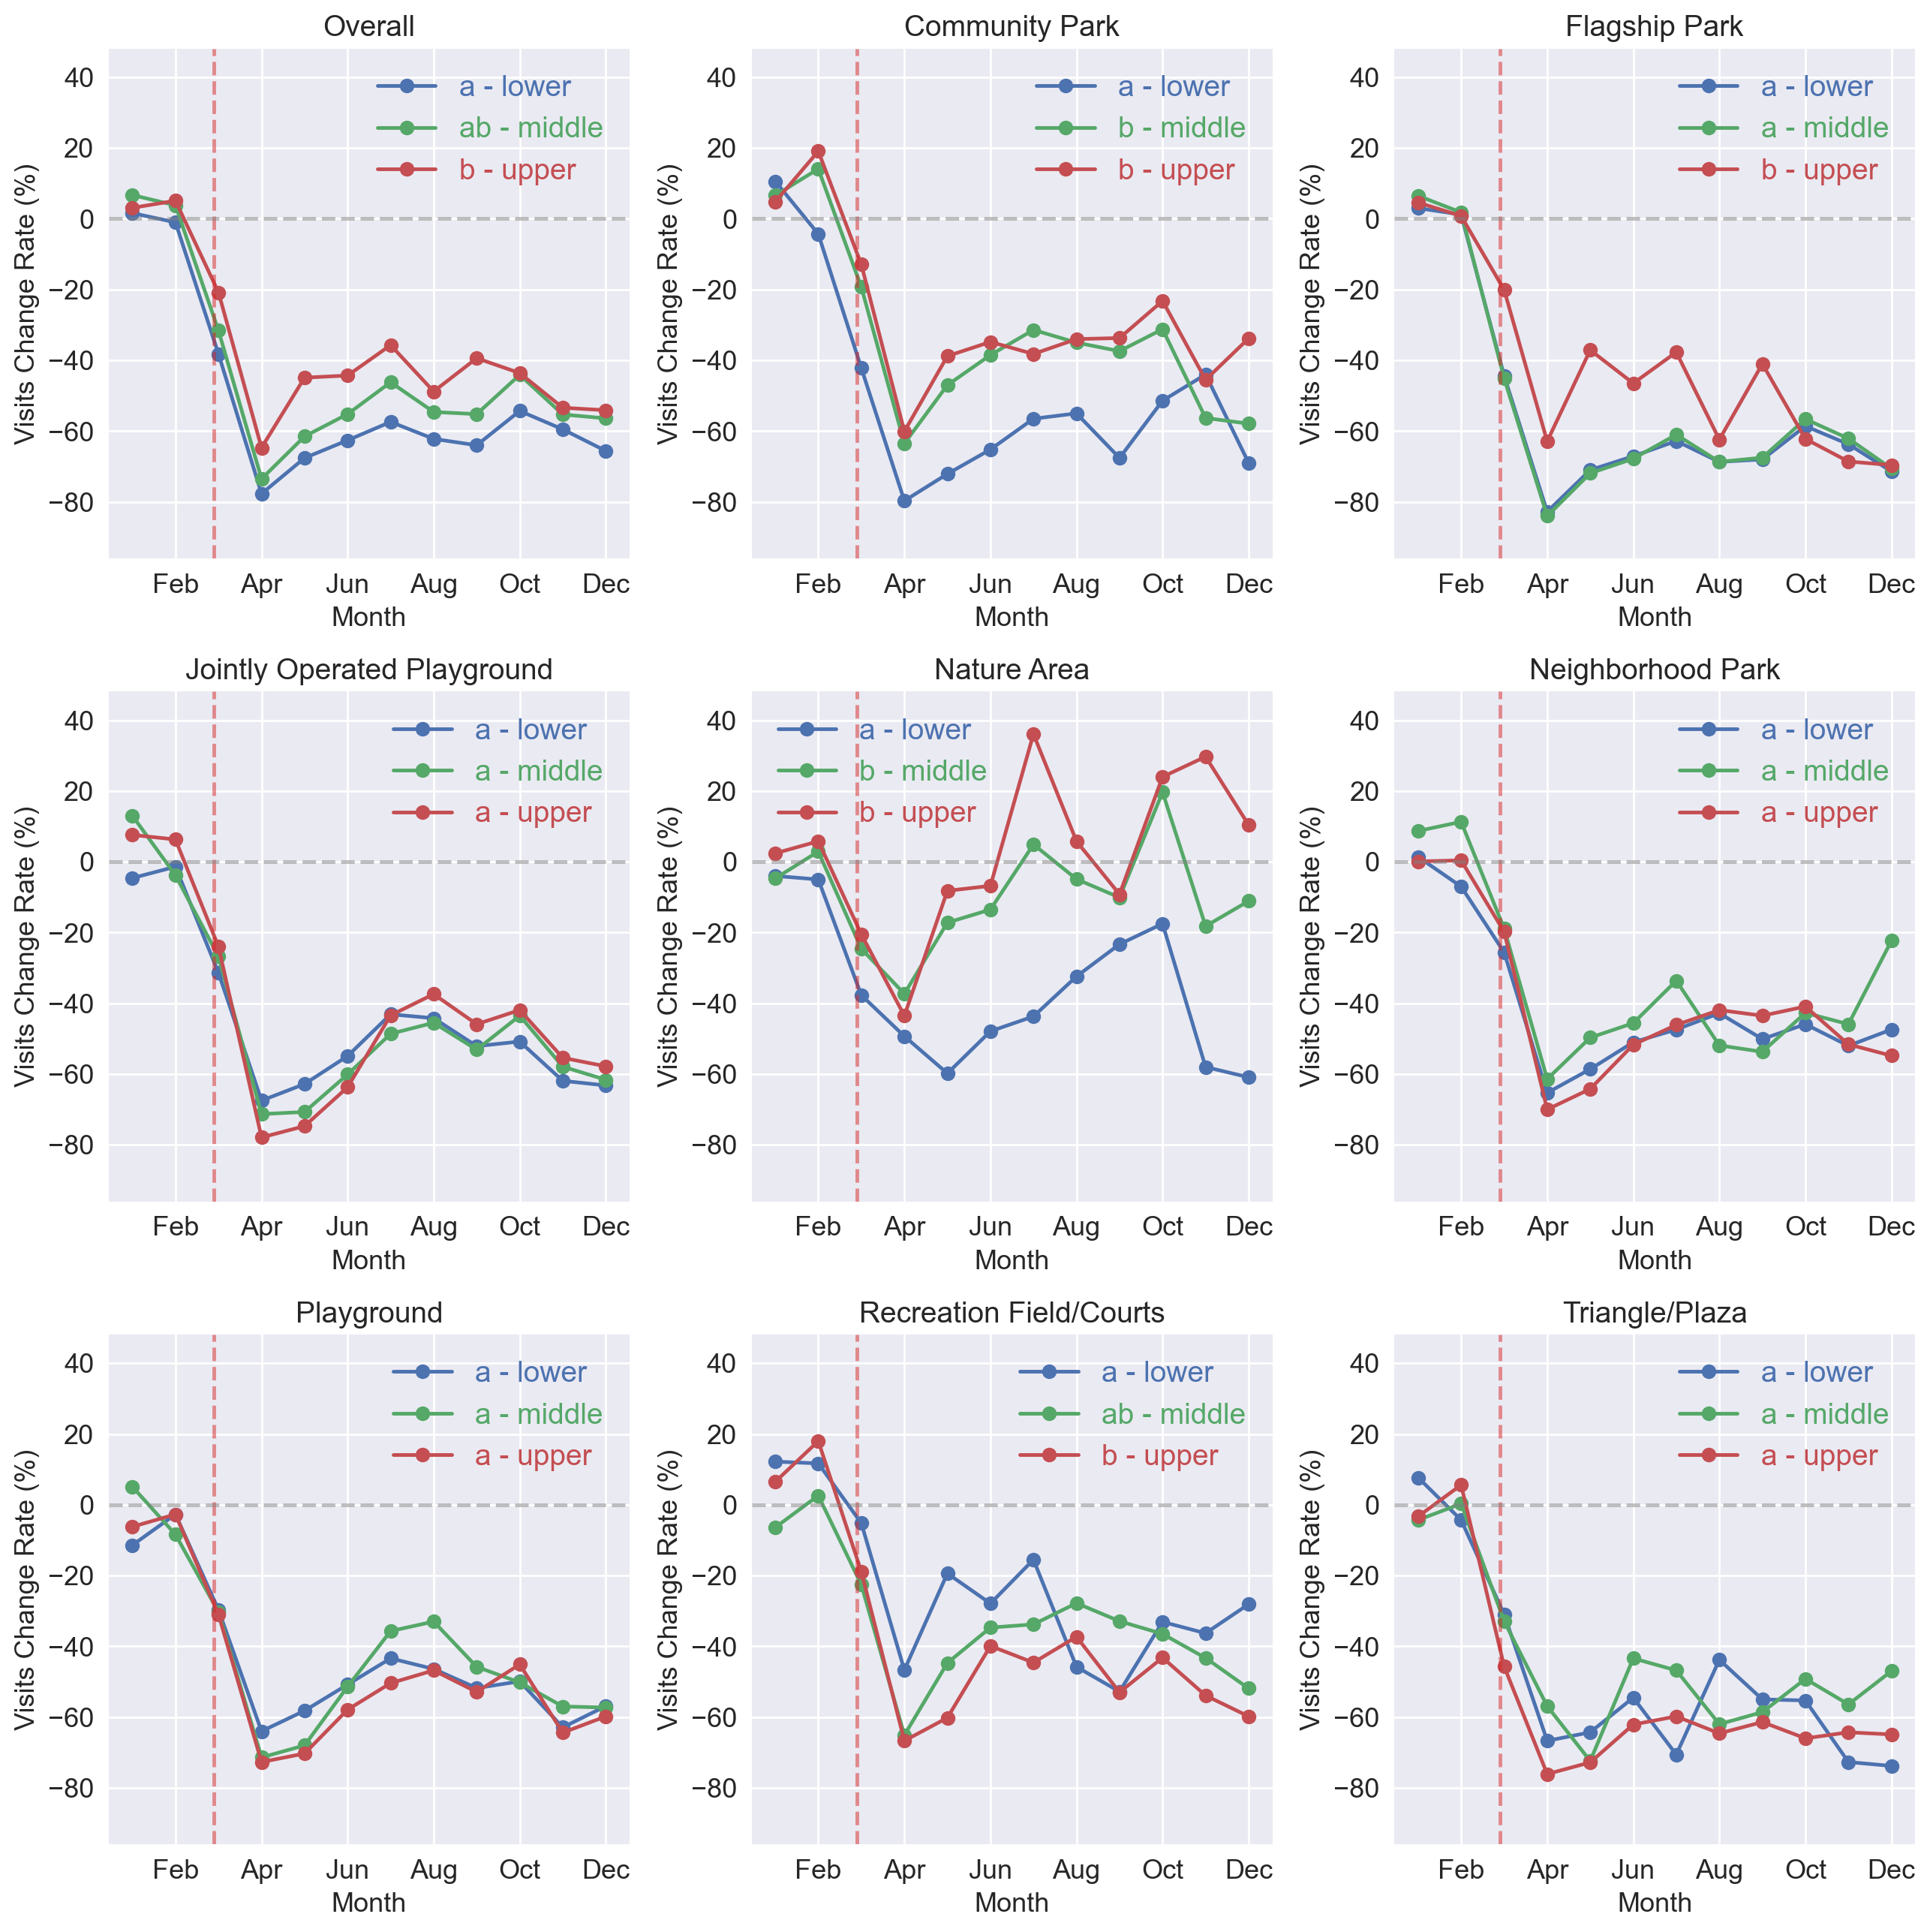

In [37]:
summary_data = summary_combined
topic_categories = major_park_types_combined
cat_col = 'income_group'
value_col = 'visits_change_rate'
ylabel = 'Visits Change Rate (%)'
tukeyhsd_labels = group_letters


pvcr.plot_by_ses_and_topic(summary_data, topic_categories, cat_col, value_col, ylabel, tukeyhsd_labels)